# Image captioning with visual attention

Ομάδα 57:

Ανδρέας Χατζησάββας 03118701

Θεόδωρος Σωτήρου 03118209

Λουκία Παυλανά 03118711

## Setup

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 17 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,153 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 7s (57.6 MB/s)
(Reading database ... 128208 files and directories currently installed.)
Removing libcudnn8-dev (8.7.0.84-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.7.0.84-1+cuda11.8 to 8.1.0.77-1+cuda11.2
(Reading database ... 128175 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.7

In [ ]:
!pip uninstall -y tensorflow estimator keras

Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Successfully uninstalled tensorflow-2.11.0
Found existing installation: keras 2.11.0
Uninstalling keras-2.11.0:
  Successfully uninstalled keras-2.11.0


In [ ]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.1 MB/s eta 0:00:00


In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.0 MB/s eta 0:00:00


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

#### Imports

In [ ]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

#### Download the dataset

In [ ]:
# Download image files
image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                      extract=True)
os.remove(image_zip)

4376381805/4376381805 [==============================] - 426s 0us/step


In [ ]:
# Download captions file
captions_file = tf.keras.utils.get_file('captions_new.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/captions_new.csv',
                                           extract=False)

# Download train files list
train_files_list = tf.keras.utils.get_file('train_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/train_files.csv',
                                           extract=False)

# Download test files list
test_files_list = tf.keras.utils.get_file('test_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/test_files.csv',
                                           extract=False)

66196/66196 [==============================] - 0s 4us/step


In [ ]:
path="."
IMAGE_DIR="image_dir"
path = pathlib.Path(path)
   
captions = (path/captions_file).read_text().splitlines()
captions = (line.split('\t') for line in captions)
captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)
   
cap_dict = collections.defaultdict(list)
for fname, cap in captions:
  cap_dict[fname].append(cap)
   
train_files = (path/train_files_list).read_text().splitlines()
train_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in train_files]
   
test_files = (path/test_files_list).read_text().splitlines()
test_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in test_files]
   
train_raw = tf.data.experimental.from_list(train_captions)
test_raw = tf.data.experimental.from_list(test_captions)

In [ ]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

### HYPERPARAMETERS

In [ ]:
vocabulary_size = 10000 #5000,6000,7000,8000,9000,10000
VOCABULARY_SIZE = 10000

#HYPERPARAMETERS
MIN_CAPTION_LEN = 4  #3,4,5,6
MAX_CAPTION_LEN = 30 #30,35,40,45

#EMBEDDINGS
#EMBEDDING_DIM = 256 # for False: default 256
EMBEDDING_DIM = 300 # for True: 50, 100, 200 or 300

### Preprocessing Data

In [ ]:
image_path_to_caption = collections.defaultdict(list)

for path, captions in train_captions:
    for caption in captions:
        image_path_to_caption[path].append(caption)
print(image_path_to_caption['image_dir/_3430497.jpg'])

['The skier is wearing a yellow jumpsuit and sliding across a yellow rail .', 'A yellow uniformed skier is performing a trick across a railed object .', 'A skier in electric green on the edge of a ramp made of metal bars .', 'A person on skis on a rail at night .', 'A skier slides along a metal rail .']


In [ ]:
#list with all the paths of the train captions
image_paths = [row[0] for row in train_captions]

Ένα "καλό" παράθυρο μήκους για τα captions αποφασίσαμε στο [4,30].

In [ ]:
caption_lengths = []
train_captions = []

for path in image_paths:
  caption_list = image_path_to_caption[path]
  for caption in caption_list:
    temp_caption_len = len(caption.split())
    if (temp_caption_len < MIN_CAPTION_LEN) or (temp_caption_len > MAX_CAPTION_LEN):
      caption_list.remove(caption)
    else:
      caption_lengths.append(temp_caption_len)
  train_captions.append((path,caption_list))    

Captions after filtering based on length: 102476


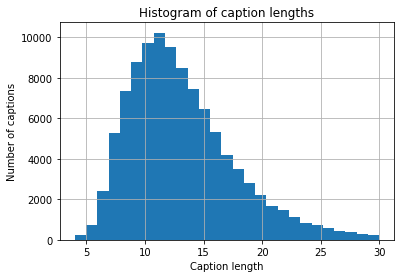

In [ ]:
print("Captions after filtering based on length:",len(caption_lengths))

n, bins, patches = plt.hist(caption_lengths, bins = (MAX_CAPTION_LEN - MIN_CAPTION_LEN + 1))
plt.xlabel('Caption length')
plt.ylabel('Number of captions')
plt.title('Histogram of caption lengths')
plt.grid(True)
plt.show()

### Image feature extractor


Δοκιμάσαμε αρκετά συνελικτικά για encoder μερικά απο τα οποία φαίνονται παρακάτω. Για το καλύτερο μας captioning επιλέξαμε τον VGG16.

InceptionV3

In [ ]:
IMAGE_SHAPE=(299, 299, 3)
InceptionV3 = tf.keras.applications.InceptionV3(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet')
InceptionV3.trainable=False

DenseNet121

In [ ]:
IMAGE_SHAPE=(224, 224, 3)
DenseNet121 = tf.keras.applications.DenseNet121(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet')
DenseNet121.trainable=False

ResNet50

In [ ]:
IMAGE_SHAPE=(224, 224, 3)
ResNet50 = tf.keras.applications.ResNet50(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet')
ResNet50.trainable=False

VGG16

In [ ]:
IMAGE_SHAPE=(224, 224, 3)
VGG16 = tf.keras.applications.VGG16(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet')
VGG16.trainable=False

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(VGG16(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 512)


### Setup the text tokenizer/vectorizer

Για την συνάρτηση standardize επιλέξαμε να μην εισάγουμε άλλα φίλτρα καθώς παρατηρήσαμε πως τα captions δεν χρειάζονταν επιπλέον επεξεργασία αφού δεν βρήκαμε περιττή πληροφορία μέσα σε αυτά.

In [ ]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

Δοκιμάσαμε διάφορα vocabulary sizes μεταξύ 5000-10000. Παρατηρήσαμε πως το μέγεθος 8000 ήταν το ιδανικό.

In [ ]:
# Use the top 5000(Default) words for a vocabulary.
vocabulary_size = 8000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

NameError: ignored

In [ ]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

In [ ]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'and', 'man']

In [ ]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 755, 5, 2, 63, 4], [3, 2, 2866, 34, 4]]>

In [ ]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [ ]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

### Prepare the datasets

The `train_raw` and `test_raw` datasets contain 1:many `(image, captions)` pairs. 

This function will replicate the image so there are 1:1 images to captions:

In [ ]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [ ]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


To be compatible with keras training the dataset should contain `(inputs, labels)` pairs. For text generation the tokens are both an input and the labels, shifted by one step. This function will convert an `(images, texts)` pair to an `((images, input_tokens), label_tokens)` pair:

In [ ]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

This function adds operations to a dataset. The steps are:

1. Load the images (and ignore images that fail to load).
2. Replicate images to match the number of captions.
3. Shuffle and rebatch the `image, caption` pairs.
4. Tokenize the text, shift the tokens and add `label_tokens`.
5. Convert the text from a `RaggedTensor` representation to padded dense `Tensor` representation.

In [ ]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

You could install the feature extractor in your model and train on the datasets like this:

In [ ]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

## Data ready for training

After those preprocessing steps, here are the datasets:

In [ ]:
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

The dataset now returns `(input, label)` pairs suitable for training with keras. The `inputs` are `(images, input_tokens)` pairs. The `images` have been processed with the feature-extractor model. For each location in the `input_tokens` the model looks at the text so far and tries to predict the next which is lined up at the same location in the `labels`.

In [ ]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 224, 224, 3)
(32, 26)
(32, 26)


The input tokens and the labels are the same, just shifted by 1 step:

In [ ]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[   3   13    5    2   22  101    8   48  128 2435   48  642    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[  13    5    2   22  101    8   48  128 2435   48  642    4    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


## A Transformer decoder model

This model assumes that the pretrained image encoder is sufficient, and just focuses on building the text decoder. This tutorial uses a 2-layer Transformer-decoder.

The implementations are almost identical to those in the [Transformers tutorial](https://www.tensorflow.org/text/tutorials/transformer). Refer back to it for more details.

<table>
<tr>
  <th>The Transformer encoder and decoder.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

The model will be implemented in three main parts: 

1. Input - The token embedding and positional encoding (`SeqEmbedding`).
1. Decoder - A stack of transformer decoder layers (`DecoderLayer`) where each contains:
   1. A causal self attention later (`CausalSelfAttention`), where each output location can attend to the output so far.
   1. A cross attention layer (`CrossAttention`) where each output location can attend to the input image.
   1. A feed forward network (`FeedForward`) layer which further processes each output location independently.
1. Output - A multiclass-classification over the output vocabulary.


### Input

The input text has already been split up into tokens and converted to sequences of IDs. 

Remember that unlike a CNN or RNN the Transformer's attention layers are invariant to the order of the sequence. Without some positional input, it just sees an unordered set not a sequence. So in addition to a simple vector embedding for each token ID, the embedding layer will also include an embedding for each position in the sequence.

The `SeqEmbedding` layer defined below:

- It looks up the embedding vector for each token.
- It looks up an embedding vector for each sequence location.
- It adds the two together.
- It uses `mask_zero=True` to initialize the keras-masks for the model.

Note: This implementation learns the position embeddings instead of using fixed embeddings like in the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer). Learning the embeddings is slightly less code, but doesn't generalize to longer sequences.

In [ ]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

With pre-trained embeddings

In [ ]:
#EMBEDDINGS
#EMBEDDING_DIM = 256 # for False: default 256
EMBEDDING_DIM = 300 # for True: 50, 100, 200 or 300

VOCABULARY_SIZE = 10000 #default

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-02-25 17:17:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-25 17:17:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-25 17:17:27--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
path_to_glove = os.path.join(os.path.expanduser("~"), "/content/glove.6B." + str(EMBEDDING_DIM) + "d.txt")


In [ ]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, embedding_dim, path_to_glove_file):
    super().__init__()

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    num_tokens = vocab_size     

    embedding_matrix = np.zeros((num_tokens, embedding_dim))

    words = tokenizer.get_vocabulary()
    for i,word in enumerate(words):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
              
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=embedding_dim)

    self.token_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
            trainable=False,
            mask_zero=True
        )
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### Decoder

The decoder is a standard Transformer-decoder, it contains a stack of `DecoderLayers` where each contains three sublayers: a `CausalSelfAttention`, a `CrossAttention`, and a`FeedForward`. The implementations are almost identical to the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer), refer to it for more details.

The `CausalSelfAttention` layer is below:

In [ ]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

The `FeedForward` layer is below. Remember that a `layers.Dense` layer is applied to the last axis of the input. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the `batch` and `sequence` axes.  

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


Next arrange these three layers into a larger `DecoderLayer`. Each decoder layer applies the three smaller layers in sequence. After each sublayer the shape of `out_seq` is `(batch, sequence, channels)`. The decoder layer also returns the `attention_scores` for later visualizations.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output

At minimum the output layer needs a `layers.Dense` layer to generate logit-predictions for each token at each location.

But there are a few other features you can add to make this work a little better:

1. **Handle bad tokens**: The model will be generating text. It should
   never generate a pad, unknown, or start token (`''`, `'[UNK]'`, 
   `'[START]'`). So set the bias for these to a large negative value.

   > Note: You'll need to ignore these tokens in the loss function as well. 

2. **Smart initialization**: The default initialization of a dense layer will
  give a model that initially predicts each token with almost uniform
  likelihood. The actual token distribution is far from uniform. The
  optimal value for the initial bias of the output layer is the log of the
  probability of each token. So include an `adapt` method to count the tokens
  and set the optimal initial bias. This reduces the initial loss from the
  entropy of the uniform distribution (`log(vocabulary_size)`) to the marginal
  entropy of the distribution (`-p*log(p)`).


In [ ]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


The smart initialization will significantly reduce the initial loss:

In [ ]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

3282it [02:25, 22.56it/s]


Uniform entropy: 9.21
Marginal entropy: 5.58


### Build the model

To build the model, you need to combine several parts:

1. The image `feature_extractor` and the text `tokenizer` and.
1. The `seq_embedding` layer, to convert batches of token-IDs to 
   vectors `(batch, sequence, channels)`.
3. The stack of `DecoderLayers` layers that will process the text and image data.
4. The `output_layer` which returns a pointwise prediction of what the next word should be.

In [ ]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer,embedding_dim,path_to_glove_file, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        max_length=max_length,
        embedding_dim=embedding_dim,
        path_to_glove_file=path_to_glove_file
        )

    self.decoder_layers = [
        DecoderLayer(embedding_dim, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

When you call the model, for training, it receives an `image, txt` pair. To make this function more usable, be flexible about the input:

* If the image has 3 channels run it through the feature_extractor. Otherwise assume that it has been already. Similarly
* If the text has dtype `tf.string` run it through the tokenizer.

After that running the model is only a few steps:

1. Flatten the extracted image features, so they can be input to the decoder layers.
2. Look up the token embeddings.
3. Run the stack of `DecoderLayer`s, on the image features and text embeddings.
4. Run the output layer to predict the next token at each position.


In [ ]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

In [ ]:
model_VGG16 = Captioner(tokenizer, feature_extractor=VGG16, output_layer=output_layer,embedding_dim=100,path_to_glove_file=path_to_glove,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

In [ ]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

TypeError: ignored

### Generate captions

Before getting into training, write a bit of code to generate captions. You'll use this to see how training is progressing.

Start by downloading a test image:

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

To caption an image with this model:

- Extract the `img_features`
- Initialize the list of output tokens with a `[START]` token.
- Pass `img_features` and `tokens` into the model.
  - It returns a list of logits.
  - Choose the next token based on those logits.  
  - Add it to the list of tokens, and continue the loop.
  - If it generates an `'[END]'` token, break out of the loop.

So add a "simple" method to do just that:

In [ ]:
@Captioner.add_method
def simple_gen(self, image, temperature=1): 
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

In [ ]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

NameError: ignored

Beam Search Implementation

In [ ]:
@Captioner.add_method
def beam_search_gen(self, image, beam_size=3):
    initial = self.word_to_index([['[START]']]) # (batch, sequence)
    img_features = self.feature_extractor(image[tf.newaxis, ...])

    # Initialize beams
    beams = [{'tokens': initial, 'score': 0.0}]
    
    for n in range(50):
        new_beams = []
        for beam in beams:
            tokens = beam['tokens']
            preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
            preds = preds[:,-1, :]  #(batch, vocab)
            
            # Get top beam_size predictions for each beam
            top_preds_idx = tf.argsort(-preds, axis=1)[:, :beam_size]
            
            for i in range(beam_size):
                next_token = top_preds_idx[0, i].numpy()
                next_score = beam['score'] - tf.math.log(preds[0, next_token]).numpy()
                new_tokens = tf.concat([tokens, [[next_token]]], axis=1)
                new_beams.append({'tokens': new_tokens, 'score': next_score})
                
        # Keep the top beam_size beams
        new_beams = sorted(new_beams, key=lambda x: x['score'])[:beam_size]
        beams = new_beams
        
        # Check if all beams have ended
        ended_beams = [beam for beam in beams if beam['tokens'][0, -1] == self.word_to_index('[END]')]
        if len(ended_beams) == len(beams):
            break
    
    # Choose the best beam
    best_beam = sorted(beams, key=lambda x: x['score'])[0]
    
    words = index_to_word(best_beam['tokens'][0, 1:-1])
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    
    return result.numpy().decode()

In [ ]:
for t in (0.0, 0.5, 1.0):
  result = model_VGG16.beam_search_gen(image, beam_size=3)
  print(result)

a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


Here are some generated captions for that image, the model's untrained, so they don't make much sense yet:

In [ ]:
for t in (0.0, 0.5, 1.0):
  result = model_VGG16.simple_gen(image, temperature=t)
  print(result)

a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
a is a a and a a a
a a twilight pinata a holding large a pedestrian wearing


The temperature parameter allows you to interpolate between 3 modes:

1. Greedy decoding (`temperature=0.0`) - Chooses the most likely next token at each step.
2. Random sampling according to the logits (`temperature=1.0`).
3. Uniform random sampling (`temperature >> 1.0`). 

Since the model is untrained, and it used the frequency-based initialization, the "greedy" output (first) usually only contains the most common tokens: `['a', '.', '[END]']`.

## Train

To train the model you'll need several additional components:

- The Loss and metrics
- The Optimizer
- Optional Callbacks

### Losses and metrics

Here's an implementation of a masked loss and accuracy:

When calculating the mask for the loss, note the `loss < 1e8`. This term discards the artificial, impossibly high losses for the `banned_tokens`.

In [ ]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

For feedback during training setup a `keras.callbacks.Callback` to generate some captions for the surfer image at the end of each epoch.

In [ ]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model_VGG16.beam_search_gen(self.image, beam_size=3)
      print(result)
    print()


It generates three output strings, like the earlier example, like before the first is "greedy", choosing the argmax of the logits at each step.

In [ ]:
g = GenerateText()
g.model_VGG16 = model_VGG16
g.on_epoch_end(0)



a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a



Also use `callbacks.EarlyStopping` to terminate training when the model starts to overfit.

In [ ]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### Train

Configure and execute the training.

In [ ]:
model_VGG16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

For more frequent reporting, use the `Dataset.repeat()` method, and set the `steps_per_epoch` and `validation_steps` arguments to `Model.fit`. 

With this setup on `Flickr8k` a full pass over the dataset is 900+ batches, but below the reporting-epochs are 100 steps.

In [ ]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

KeyboardInterrupt: ignored

Plot the loss and accuracy over the training run:

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Attention plots

Now, using the trained model,  run that `simple_gen` method on the image:

In [ ]:
result = model.simple_gen(image, temperature=0.0)
result

Split the output back into tokens:

In [ ]:
str_tokens = result.split()
str_tokens.append('[END]')

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [ ]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

So stack the maps along the `batch` axis, then average over the `(batch, heads)` axes, while splitting the `image` axis back into `height, width`:


In [ ]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

Now you have a single attention map, for each sequence prediction. The values in each map should sum to `1.`

In [ ]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

So here is where the model was focusing attention while generating each token of the output:

In [ ]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

In [ ]:
plot_attention_maps(image/255, str_tokens, attention_maps)

Now put that together into a more usable function:

In [ ]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)


In [ ]:
run_and_show_attention(model, image)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for strange results!)


In [ ]:
image_url = 'https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)

In [ ]:
import nltk
from nltk.translate.bleu_score import SmoothingFunction
weights = (0.4, 0.3, 0.2, 0.1)
smoothing_function = SmoothingFunction().method1

def sentence_bleu_calc(references,hyp):
  return(nltk.translate.bleu_score.sentence_bleu(
                                          references, 
                                          hyp, 
                                          weights = weights, 
                                          smoothing_function=smoothing_function))

def corpus_bleu_calc(list_of_references, list_of_hypotheses):
  return(nltk.translate.bleu_score.corpus_bleu(list_of_references, 
                                               list_of_hypotheses, 
                                               weights = weights, 
                                               smoothing_function=smoothing_function))

In [ ]:
image_references = [row[1] for row in test_captions]
references = [[s.split()[:-1] for s in sublist] for sublist in image_references]
image_paths = [row[0] for row in test_captions]

In [ ]:
myimage = load_image(image_paths[0])
myhyp = model_VGG19.simple_gen(myimage).split()
sentence_bleu_calc(references[0],myhyp)

##Encoder optimization

### RestNet152V2

In [ ]:
IMAGE_SHAPE=(224, 224, 3)
ResNet152V2 = tf.keras.applications.ResNet152V2(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet')
ResNet152V2.trainable=False

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

train_ds_ResNet152V2 = train_ds
test_ds_ResNet152V2 = test_ds
#save_dataset(train_raw, 'ResNet152V2_train_cache', ResNet152V2, tokenizer)
#save_dataset(test_raw, 'ResNet152V2_test_cache', ResNet152V2, tokenizer)

#train_ds_ResNet152V2 = load_dataset('ResNet152V2_train_cache')
#test_ds_ResNet152V2 = load_dataset('ResNet152V2_test_cache')

model_ResNet152V2 = Captioner(tokenizer, feature_extractor=ResNet152V2, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)
model_ResNet152V2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])
history_ResNet152V2 = model_ResNet152V2.fit(
    train_ds_ResNet152V2.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds_ResNet152V2.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

###VGG16

In [ ]:
IMAGE_SHAPE=(224, 224, 3)
VGG16 = tf.keras.applications.VGG16(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet')
VGG16.trainable=False

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

train_ds_VGG16 = train_ds
test_ds_VGG16 = test_ds
#save_dataset(train_raw, 'VGG16_train_cache', VGG16, tokenizer)
#save_dataset(test_raw, 'VGG16_test_cache', VGG16, tokenizer)

#train_ds_VGG16 = load_dataset('VGG16_train_cache')
#test_ds_VGG16 = load_dataset('VGG16_test_cache')

model_VGG16 = Captioner(tokenizer, feature_extractor=VGG16, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)
model_VGG16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])
history_VGG16 = model_VGG16.fit(
    train_ds_VGG16.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds_VGG16.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

In [ ]:
myimage = load_image(image_paths[0])
myhyp = model_VGG16.simple_gen(myimage).split()
print(myhyp)
sentence_bleu_calc(references[0],myhyp)

In [ ]:
VGG19_hypothesis_captions = []

for i_path in image_paths[:100]:
  i_image = load_image(i_path)
  i_hyp = model_VGG19.simple_gen(i_image).split()
  VGG19_hypothesis_captions.append(i_hyp)

In [ ]:
corpus_bleu_calc(references[:100], VGG16_hypothesis_captions)

###InceptionV3

In [ ]:
IMAGE_SHAPE=(299, 299, 3)
InceptionV3 = tf.keras.applications.InceptionV3(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet')
InceptionV3.trainable=False

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

train_ds_InceptionV3 = train_ds
test_ds_InceptionV3 = test_ds
#save_dataset(train_raw, 'InceptionV3_train_cache', InceptionV3, tokenizer)
#save_dataset(test_raw, 'InceptionV3_test_cache', InceptionV3, tokenizer)

#train_ds_InceptionV3 = load_dataset('InceptionV3_train_cache')
#test_ds_InceptionV3 = load_dataset('InceptionV3_test_cache')

model_InceptionV3 = Captioner(tokenizer, feature_extractor=InceptionV3, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)
model_InceptionV3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])
history_InceptionV3 = model_InceptionV3.fit(
    train_ds_InceptionV3.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds_InceptionV3.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

###ResNet50

In [ ]:
IMAGE_SHAPE=(224, 224, 3)
ResNet50 = tf.keras.applications.ResNet50(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet')
ResNet50.trainable=False

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

train_ds_ResNet50 = train_ds
test_ds_ResNet50 = test_ds
#save_dataset(train_raw, 'ResNet50_train_cache', ResNet50, tokenizer)
#save_dataset(test_raw, 'ResNet50_test_cache', ResNet50, tokenizer)

#train_ds_ResNet50 = load_dataset('ResNet50_train_cache')
#test_ds_ResNet50 = load_dataset('ResNet50_test_cache')

model_ResNet50 = Captioner(tokenizer, feature_extractor=ResNet50, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)
model_ResNet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])
history_ResNet50 = model_ResNet50.fit(
    train_ds_ResNet50.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds_ResNet50.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

94765736/94765736 [==============================] - 4s 0us/step


TypeError: ignored

In [ ]:
myimage = load_image(image_paths[0])
myhyp = model_ResNet50.simple_gen(myimage).split()
print(myhyp)
sentence_bleu_calc(references[0],myhyp)

In [ ]:
ResNet50_hypothesis_captions = []

for i_path in image_paths[:100]:
  i_image = load_image(i_path)
  i_hyp = model_ResNet50.simple_gen(i_image).split()
  ResNet50_hypothesis_captions.append(i_hyp)

In [ ]:
corpus_bleu_calc(references[:100], ResNet50_hypothesis_captions)

###DenseNet121

In [ ]:
IMAGE_SHAPE=(224, 224, 3)
DenseNet121 = tf.keras.applications.DenseNet121(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet')
DenseNet121.trainable=False

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

train_ds_DenseNet121 = train_ds
test_ds_DenseNet121 = test_ds
#save_dataset(train_raw, 'DenseNet121_train_cache', DenseNet121, tokenizer)
#save_dataset(test_raw, 'DenseNet121_test_cache', DenseNet121, tokenizer)

#train_ds_DenseNet121 = load_dataset('DenseNet121_train_cache')
#test_ds_DenseNet121 = load_dataset('DenseNet121_test_cache')

model_DenseNet121 = Captioner(tokenizer, feature_extractor=DenseNet121, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)
model_DenseNet121.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])
history_DenseNet121 = model_DenseNet121.fit(
    train_ds_DenseNet121.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds_DenseNet121.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

In [ ]:
myimage = load_image(image_paths[0])
myhyp = model_DenseNet121.simple_gen(myimage).split()
print(myhyp)
sentence_bleu_calc(references[0],myhyp)

In [ ]:
DenseNet121_hypothesis_captions = []

for i_path in image_paths[:100]:
  i_image = load_image(i_path)
  i_hyp = model_DenseNet121.simple_gen(i_image).split()
  DenseNet121_hypothesis_captions.append(i_hyp)

In [ ]:
corpus_bleu_calc(references[:100], DenseNet121_hypothesis_captions)

###Embeddings

In [ ]:
IMAGE_SHAPE=(224, 224, 3)
VGG16 = tf.keras.applications.VGG16(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet')
VGG16.trainable=False

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

train_ds_VGG16 = train_ds
test_ds_VGG16 = test_ds
#save_dataset(train_raw, 'VGG16_train_cache', VGG16, tokenizer)
#save_dataset(test_raw, 'VGG16_test_cache', VGG16, tokenizer)

#train_ds_VGG16 = load_dataset('VGG16_train_cache')
#test_ds_VGG16 = load_dataset('VGG16_test_cache')

model_VGG16 = Captioner(tokenizer, feature_extractor=VGG16, output_layer=output_layer,embedding_dim=100,path_to_glove_file=path_to_glove,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)
model_VGG16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])
history_VGG16 = model_VGG16.fit(
    train_ds_VGG16.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds_VGG16.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 5.5157 - masked_acc: 0.1419

a
a in a a girl is with a in a
a these heart for in toward a large

100/100 [==============================] - 46s 313ms/step - loss: 5.5157 - masked_acc: 0.1419 - val_loss: 5.3717 - val_masked_acc: 0.1778
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 5.3122 - masked_acc: 0.1886

a man man man man man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in
a man in a man in the in a man playing
wearing band herself it tugofwar

100/100 [==============================] - 30s 304ms/step - loss: 5.3122 - masked_acc: 0.1886 - val_loss: 5.1885 - val_masked_acc: 0.2011
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 5.1493 - masked_acc: 0.2109

a man in a man in a man
a looks in a with the are is on the is
a is a spread a rifle square boy forehead shirt on a tightrope leathe

In [ ]:
history_VGG16 = model_VGG16.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100


In [ ]:
myimage = load_image(image_paths[0])
myhyp = model_VGG16.simple_gen(myimage).split()
print(myhyp)
sentence_bleu_calc(references[0],myhyp)

['five', 'dogs', 'with', 'black', 'holding', 'establishment', 'his', 'boots', 'coat', 'in', 'a', 'cityscape', 'park', 'do', 'holding', 'into', 'a', 'lab', 'while', 'a', 'little', 'pole']


0.05489335497418165

In [ ]:
VGG16_hypothesis_captions = []

for i_path in image_paths[:150]:
  i_image = load_image(i_path)
  i_hyp = model_VGG16.simple_gen(i_image).split()
  VGG16_hypothesis_captions.append(i_hyp)

In [ ]:
corpus_bleu_calc(references[:150], VGG16_hypothesis_captions)

0.05851768275813604

# Image captioning with visual attention

Ομάδα 57:

Ανδρέας Χατζησάββας 03118701

Θεόδωρος Σωτήρου 03118209

Λουκία Παυλανά 03118711

### Setup

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
0 upgraded, 0 newly installed, 0 to remove and 17 not upgraded.


In [ ]:
!pip uninstall -y tensorflow estimator keras

Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Successfully uninstalled tensorflow-2.11.0
Found existing installation: keras 2.11.0
Uninstalling keras-2.11.0:
  Successfully uninstalled keras-2.11.0


In [ ]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-2.11.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)


In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Imports

In [ ]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import nltk
from nltk.translate.bleu_score import SmoothingFunction

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

#### Download the dataset

In [ ]:
# Download image files
image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                      extract=True)
os.remove(image_zip)

4376381805/4376381805 [==============================] - 440s 0us/step


In [ ]:
# Download captions file
captions_file = tf.keras.utils.get_file('captions_new.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/captions_new.csv',
                                           extract=False)

# Download train files list
train_files_list = tf.keras.utils.get_file('train_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/train_files.csv',
                                           extract=False)

# Download test files list
test_files_list = tf.keras.utils.get_file('test_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/test_files.csv',
                                           extract=False)

In [ ]:
path="."
IMAGE_DIR="image_dir"
path = pathlib.Path(path)
   
captions = (path/captions_file).read_text().splitlines()
captions = (line.split('\t') for line in captions)
captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)
   
cap_dict = collections.defaultdict(list)
for fname, cap in captions:
  cap_dict[fname].append(cap)
   
train_files = (path/train_files_list).read_text().splitlines()
train_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in train_files]
   
test_files = (path/test_files_list).read_text().splitlines()
test_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in test_files]
   
train_raw = tf.data.experimental.from_list(train_captions)
test_raw = tf.data.experimental.from_list(test_captions)

In [ ]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [ ]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'image_dir/_3430497.jpg', shape=(), dtype=string)
tf.Tensor(
[b'The skier is wearing a yellow jumpsuit and sliding across a yellow rail .'
 b'A yellow uniformed skier is performing a trick across a railed object .'
 b'A skier in electric green on the edge of a ramp made of metal bars .'
 b'A person on skis on a rail at night .'
 b'A skier slides along a metal rail .'], shape=(5,), dtype=string)


### HYPERPARAMETERS

In [ ]:
vocabulary_size = 10000 #5000,6000,7000,8000,9000,10000
VOCABULARY_SIZE = 10000

#HYPERPARAMETERS
MIN_CAPTION_LEN = 4
MAX_CAPTION_LEN = 30

#EMBEDDINGS
#EMBEDDING_DIM = 256 # for False: default 256
EMBEDDING_DIM = 300 # for True: 50, 100, 200 or 300

### Preprocessing Data

In [ ]:
image_path_to_caption = collections.defaultdict(list)

for path, captions in train_captions:
    for caption in captions:
        image_path_to_caption[path].append(caption)
print(image_path_to_caption['image_dir/_3430497.jpg'])

['The skier is wearing a yellow jumpsuit and sliding across a yellow rail .', 'A yellow uniformed skier is performing a trick across a railed object .', 'A skier in electric green on the edge of a ramp made of metal bars .', 'A person on skis on a rail at night .', 'A skier slides along a metal rail .']


In [ ]:
#list with all the paths of the train captions
image_paths = [row[0] for row in train_captions]

Ένα "καλό" παράθυρο μήκους για τα captions αποφασίσαμε στο [4,30].

In [ ]:
caption_lengths = []
train_captions = []

for path in image_paths:
  caption_list = image_path_to_caption[path]
  for caption in caption_list:
    temp_caption_len = len(caption.split())
    if (temp_caption_len < MIN_CAPTION_LEN) or (temp_caption_len > MAX_CAPTION_LEN):
      caption_list.remove(caption)
    else:
      caption_lengths.append(temp_caption_len)
  train_captions.append((path,caption_list))    

Captions after filtering based on length: 102476


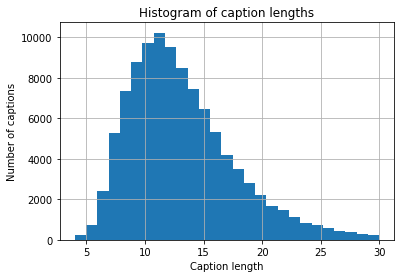

In [ ]:
print("Captions after filtering based on length:",len(caption_lengths))

n, bins, patches = plt.hist(caption_lengths, bins = (MAX_CAPTION_LEN - MIN_CAPTION_LEN + 1))
plt.xlabel('Caption length')
plt.ylabel('Number of captions')
plt.title('Histogram of caption lengths')
plt.grid(True)
plt.show()

### Image feature extractor


Δοκιμάσαμε αρκετά συνελικτικά για encoder μερικά απο τα οποία φαίνονται παρακάτω. Για το καλύτερο μας captioning επιλέξαμε τον VGG16.

InceptionV3

In [ ]:
IMAGE_SHAPE=(299, 299, 3)
InceptionV3 = tf.keras.applications.InceptionV3(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet')
InceptionV3.trainable=False

DenseNet121

In [ ]:
IMAGE_SHAPE=(224, 224, 3)
DenseNet121 = tf.keras.applications.DenseNet121(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet')
DenseNet121.trainable=False

ResNet50

In [ ]:
IMAGE_SHAPE=(224, 224, 3)
ResNet50 = tf.keras.applications.ResNet50(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet')
ResNet50.trainable=False

VGG16

In [ ]:
IMAGE_SHAPE=(224, 224, 3)
VGG16 = tf.keras.applications.VGG16(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet')
VGG16.trainable=False

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

In [ ]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(VGG16(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 512)


### Setup the text tokenizer/vectorizer

Για την συνάρτηση standardize επιλέξαμε να μην εισάγουμε άλλα φίλτρα καθώς παρατηρήσαμε πως τα captions δεν χρειάζονταν επιπλέον επεξεργασία αφού δεν βρήκαμε περιττή πληροφορία μέσα σε αυτά.

In [ ]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

Δοκιμάσαμε διάφορα vocabulary sizes μεταξύ 5000-10000. Παρατηρήσαμε πως το μέγεθος 8000 ήταν το ιδανικό.

In [ ]:
# Use the top 5000(Default) words for a vocabulary.
vocabulary_size = 8000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [ ]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

### Prepare the datasets

The `train_raw` and `test_raw` datasets contain 1:many `(image, captions)` pairs. 

This function will replicate the image so there are 1:1 images to captions:

In [ ]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [ ]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)

image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


To be compatible with keras training the dataset should contain `(inputs, labels)` pairs. For text generation the tokens are both an input and the labels, shifted by one step. This function will convert an `(images, texts)` pair to an `((images, input_tokens), label_tokens)` pair:

In [ ]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

This function adds operations to a dataset. The steps are:

1. Load the images (and ignore images that fail to load).
2. Replicate images to match the number of captions.
3. Shuffle and rebatch the `image, caption` pairs.
4. Tokenize the text, shift the tokens and add `label_tokens`.
5. Convert the text from a `RaggedTensor` representation to padded dense `Tensor` representation.

In [ ]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

In [ ]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

## Data ready for training

After those preprocessing steps, here are the datasets:

In [ ]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 224, 224, 3)
(32, 33)
(32, 33)


In [ ]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[  3   2   9   5   2  27  23  10 171 250   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  2   9   5   2  27  23  10 171 250   4   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


## A Transformer decoder model

The model will be implemented in three main parts: 

1. Input - The token embedding and positional encoding (`SeqEmbedding`).
1. Decoder - A stack of transformer decoder layers (`DecoderLayer`) where each contains:
   1. A causal self attention later (`CausalSelfAttention`), where each output location can attend to the output so far.
   1. A cross attention layer (`CrossAttention`) where each output location can attend to the input image.
   1. A feed forward network (`FeedForward`) layer which further processes each output location independently.
1. Output - A multiclass-classification over the output vocabulary.


### Input with Pre-trained Embeddings of size 300

Αντί embeddings που μαθαίνονται κατά την εκπαίδευση του μοντέλου προτιμήσαμε έτοιμα embeddings με μεταφορά μάθησης. Το δίκτυο απέδιδε καλύτερα με embeddings διαστάσεων 300.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-02-26 18:00:47--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-26 18:00:47--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-26 18:00:48--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
path_to_glove = os.path.join(os.path.expanduser("~"), "/content/glove.6B." + str(EMBEDDING_DIM) + "d.txt")

Τροποποιήσαμε την κλάση SeqEmbedding ώστε να εισάγει τα pre-trained Embeddings.

In [ ]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, embedding_dim, path_to_glove_file):
    super().__init__()

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    num_tokens = vocab_size     

    embedding_matrix = np.zeros((num_tokens, embedding_dim))

    words = tokenizer.get_vocabulary()
    for i,word in enumerate(words):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
              
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=embedding_dim)

    self.token_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
            trainable=False,
            mask_zero=True
        )
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### Decoder

The decoder is a standard Transformer-decoder, it contains a stack of `DecoderLayers` where each contains three sublayers: a `CausalSelfAttention`, a `CrossAttention`, and a`FeedForward`. The implementations are almost identical to the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer).

The `CausalSelfAttention` layer is below:

In [ ]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)

The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

The `FeedForward` layer is below. Remember that a `layers.Dense` layer is applied to the last axis of the input. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the `batch` and `sequence` axes.  

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output

In [ ]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias

The smart initialization will significantly reduce the initial loss:

In [ ]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

3282it [02:54, 18.80it/s]


Uniform entropy: 8.99
Marginal entropy: 5.55


### Build the model

Κάναμε τις απαραίτητες αλλαγές στον Captioner σύμφωνα με τις αλλαγές που κάναμε.

In [ ]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer,embedding_dim,path_to_glove_file, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        max_length=max_length,
        embedding_dim=embedding_dim,
        path_to_glove_file=path_to_glove_file
        )

    self.decoder_layers = [
        DecoderLayer(embedding_dim, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

In [ ]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

In [ ]:
model_VGG16 = Captioner(tokenizer, feature_extractor=VGG16, output_layer=output_layer,embedding_dim=300,path_to_glove_file=path_to_glove,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

### Generate captions

Before getting into training, write a bit of code to generate captions. You'll use this to see how training is progressing.

Start by downloading a test image:

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

To caption an image with this model:

- Extract the `img_features`
- Initialize the list of output tokens with a `[START]` token.
- Pass `img_features` and `tokens` into the model.
  - It returns a list of logits.
  - Choose the next token based on those logits.  
  - Add it to the list of tokens, and continue the loop.
  - If it generates an `'[END]'` token, break out of the loop.

So add a "simple" method to do just that:

In [ ]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

Caption Image using Beam Search of beam size 4

Τροποποιήσαμε τα ορίσματα της simple_gen ώστε να καλύπτει και το Beam Search.

In [ ]:
@Captioner.add_method
def simple_gen(self, image, beam_size=4):
  initial = self.word_to_index([['[START]']])                        # 'START' token == 3
  img_features = self.feature_extractor(image[tf.newaxis, ...])      # extract features from image

  tokens_list = [(initial, 0.0)]                  # list of tuples (tokens, propability): stores the top b sentences for each branch (in each iteration)
  final_tokens_list = []                          # list of tuples (tokens, propability): final top b selected sentences

  remaining_beam_size = beam_size                 # Counter for how many branches in the beam search tree have not terminated yet
  for n in range(50):
    if remaining_beam_size == 0:
      break
    new_tokens_list = []                          # top_b tokens for each branch (b*b tokens)
    for tokens, prob in tokens_list:              # tokens: [3, 15, 22, 10, ...], prob: float (ex. 0.23)
      if tokens[0][-1] == self.word_to_index('[END]'):
        remaining_beam_size -= 1
        final_tokens_list.append((tokens, prob))
        continue
      preds = self((img_features, tokens)).numpy()    # generate probabilities for all words given a sentence 'tokens' and an image 'img_features'
      preds = preds[:, -1, :]                         # get the probabilities vector only for the last word
      top_b_preds = tf.math.top_k(preds, k=remaining_beam_size) # get the b words with the biggest probability
      top_b_tokens = top_b_preds.indices              # tokens 
      top_b_prob = top_b_preds.values                 # probabilities
      for i in range(remaining_beam_size):
        next_token = [[top_b_tokens[0][i]]]           # next token to be added to the sentence (in one branch)
        new_tokens = tf.concat([tokens, next_token], axis=1)
        new_log_prob = prob + top_b_prob[0][i]
        new_tokens_list.append((new_tokens, new_log_prob))
      
    tokens_list = sorted(new_tokens_list, key=lambda x: -x[1])[:remaining_beam_size] # Sort the list with b*b sentences and keep the first b

  # Return the sentence with the biggest (probability / sentence length) score
  tokens, prob = max(final_tokens_list, key=lambda x: x[1]/len(x[0][0, 1:-1]))
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  
  return result.numpy().decode()

Here are some generated captions for that image, the model's untrained, so they don't make much sense yet:

In [ ]:
for t in (0.0, 0.5, 1.0):
  result = model_VGG16.simple_gen(image, beam_size=4)
  print(result)

a a
a a
a a


## Train


### Losses and metrics

Here's an implementation of a masked loss and accuracy:

When calculating the mask for the loss, note the `loss < 1e8`. This term discards the artificial, impossibly high losses for the `banned_tokens`.

In [ ]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

GenerateText - Bean Search Gen

In [ ]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, beam_size=4)
      print(result)
    print()

In [ ]:
g = GenerateText()
g.model = model_VGG16
g.on_epoch_end(0)



a a
a a
a a



In [ ]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### Train

In [ ]:
model_VGG16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [ ]:
history_VGG16 = model_VGG16.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 5.2482 - masked_acc: 0.1914

a man in a man in a man in the
a man in a man in a man in the
a man in a man in a man in the

100/100 [==============================] - 80s 607ms/step - loss: 5.2482 - masked_acc: 0.1914 - val_loss: 5.0346 - val_masked_acc: 0.2217
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 4.8840 - masked_acc: 0.2420

a man in the water
a man in the water
a man in the water

100/100 [==============================] - 36s 361ms/step - loss: 4.8840 - masked_acc: 0.2420 - val_loss: 4.7591 - val_masked_acc: 0.2535
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 4.7515 - masked_acc: 0.2515

a man in the water
a man in the water
a man in the water

100/100 [==============================] - 31s 316ms/step - loss: 4.7515 - masked_acc: 0.2515 - val_loss: 4.6103 - val_masked_acc: 0.2574
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 4.626

### Bleu Scores

In [ ]:
weights = (0.4, 0.3, 0.2, 0.1)
smoothing_function = SmoothingFunction().method1

def sentence_bleu_calc(references,hyp):
  return(nltk.translate.bleu_score.sentence_bleu(
                                          references, 
                                          hyp, 
                                          weights = weights, 
                                          smoothing_function=smoothing_function))

def corpus_bleu_calc(list_of_references, list_of_hypotheses):
  return(nltk.translate.bleu_score.corpus_bleu(list_of_references, 
                                               list_of_hypotheses, 
                                               weights = weights, 
                                               smoothing_function=smoothing_function))

In [ ]:
image_references = [row[1] for row in test_captions]
references = [[s.split()[:-1] for s in sublist] for sublist in image_references]
image_paths = [row[0] for row in test_captions]

#### Bleu score for a singular image

In [ ]:
myimage = load_image(image_paths[0])
myhyp = model_VGG16.simple_gen(myimage).split()
print(myhyp)
sentence_bleu_calc(references[0],myhyp)

['a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'running', 'through', 'a', 'field']


0.2315817779303589

#### Bleu Score for a larger dataset

In [ ]:
VGG16_hypothesis_captions = []

for i_path in image_paths[:1000]:
  i_image = load_image(i_path)
  i_hyp = model_VGG16.simple_gen(i_image,beam_size=4).split()
  VGG16_hypothesis_captions.append(i_hyp)

In [ ]:
corpus_bleu_calc(references[:1000], VGG16_hypothesis_captions)

0.19638853668023262